# Training a recurrent neural network
Draft scripts using GRU/ LSTMs on individual user activity streams

This is the precursor to the python scripts for training GRUs / LSTMs.

Ultimately it was decided that training would take too long, and that, at least for the time frame of this project, ensemble approaches are more advantageous.

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU 
from keras.layers import Merge
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Conv2D, GlobalMaxPooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MaxAbsScaler

import psycopg2
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

import keras_functions
from keras_functions import *

In [1333]:
binvars = get_categorical_variables([
    'all_participanttypes',
    'all_language'
])

In [1334]:
tags = get_categorical_variables(['all_tags'])

# Initial pipeline

In [501]:
with open('set_train.txt') as f:
    train_handles = [h.strip() for h in f.readlines()]
with open('set_test.txt') as f:
    test_handles = [h.strip() for h in f.readlines()]
with open('set_val.txt') as f:
    val_handles = [h.strip() for h in f.readlines()]

In [1335]:
# user columns can be out of order, use tourist's as correct order
with open('rnn_train/tourist.csv') as f:
    correct_cols = [t.strip() for t in f.readline().split(',')]

In [1336]:
correct_cols = [c for c in correct_cols if c not in tags]

In [ ]:
from os.path import exists
reload(keras_functions)
maxtimepts = 200

th = [ "abyssmall", "razia_sultana", "ufo", "williamhu08", "rdfz_yjy", "k21", "rudradevbasak", "ch_egor", "FreeMoneyCity", "Gomhog", "Life_is_like_a_boat", "MikhailRubinchik", "Oleg_Smirnov", "jiangshibiao", "Dembel", "Logic_zys", "Shayan_Jahan", "dc.", "wakaka", "chnluyi", "Koreyoshi_", "vlecomte", "AleksanderBalobanov", "Gerald", "hex539", "lovro", "MKLOL", "RNS", "gskhirtladze", "jzzhu", "Ai_AA", "JeBeK", "MHR", "alex256", "darknstd", "dragoon", "feyat" ]
X, Y, lens_tr, maxt = keras_functions.get_train_data(th, binvars, correct_cols, maxtimepts)

#Xval, Yval, lens_val, maxt = keras_functions.get_train_data(val_handles[0:10], binvars, correct_cols, maxtimepts)

In [1381]:
reload(keras_functions)
maxtimepts = 200
X, Y, lens_tr, maxt, colnames = keras_functions.get_train_data(['sanket407'], binvars, correct_cols, maxtimepts) #jiyutian

rnn_train/sanket407.csv


# Scaling
For NN, feature scaling is extremely important


In [1383]:
Xflat = np.concatenate(X)
print Xflat.shape
Xflat = np.reshape(Xflat, [Xflat.shape[0]*Xflat.shape[1], Xflat.shape[2]])
print Xflat.shape
#scaler = MaxAbsScaler().fit(Xflat)

(28, 200, 16)
(5600, 16)


In [525]:
th2 = [ "123qws", "613", "Alona", "AstroConjecture", "chipchip3412", "hmich   ", "mstczuo", "pandazcy", "Fefer_Ivan", "edward_mj", "jerjeriscute", "-Wave-", "Constantius", "I_dont_have_girlfriend", "SealView", "antonkov" ]
Xval, Yval, lens_val, maxt = keras_functions.get_train_data(th2, binvars, correct_cols, maxtimepts)

rnn_train/123qws.csv
rnn_train/613.csv
rnn_train/Alona.csv
rnn_train/AstroConjecture.csv
rnn_train/chipchip3412.csv
rnn_train/hmich   .csv
rnn_train/mstczuo.csv
rnn_train/pandazcy.csv
rnn_train/Fefer_Ivan.csv
rnn_train/edward_mj.csv
rnn_train/jerjeriscute.csv
rnn_train/-Wave-.csv
rnn_train/Constantius.csv
rnn_train/I_dont_have_girlfriend.csv
rnn_train/SealView.csv
rnn_train/antonkov.csv


In [ ]:
xmax = np.max(Xflat, axis=0)
xmax[xmax == 0] = 1

In [1405]:
month = 3
colnames_rate = ['smoothed_%dmonths'%month, 'oldrating', 'problem_rating']
maxrating = 5000.0
idx_rate = [colnames.index(c) for c in colnames_rate]
xmax[idx_rate] = maxrating

# Define model

In [1436]:
reload(keras_functions)
batchsize = X[0].shape
gru1 = 6
gru2 = 3
dense = 50
model = keras_functions.create_model([gru1, gru2, dense], batchsize)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_134 (Masking)        (28, 200, 16)             0         
_________________________________________________________________
gru_241 (GRU)                (28, 200, 6)              396       
_________________________________________________________________
gru_242 (GRU)                (28, 3)                   81        
_________________________________________________________________
dense_235 (Dense)            (28, 50)                  150       
_________________________________________________________________
dropout_144 (Dropout)        (28, 50)                  0         
_________________________________________________________________
dense_236 (Dense)            (28, 1)                   50        
Total params: 677
Trainable params: 677
Non-trainable params: 0
_________________________________________________________________


In [1440]:
optimizer = keras.optimizers.RMSprop(lr=0.01, decay=0.05)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

Train on one person--see if this works at all

In [1438]:
history = []
epochs = 100
ymax = 300.0

xin = X[0]/xmax
yin = Y[0]/ymax

for i in range(epochs):
    h = model.fit(xin, yin, epochs=1, shuffle=False, batch_size=batchsize[0], verbose=1)
    model.reset_states()
    history.append(h)

Epoch 1/1
28/28 [==============================] - 10s - loss: 0.0260 - mean_absolute_error: 0.1239
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0600 - mean_absolute_error: 0.1853
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0142 - mean_absolute_error: 0.0903
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0178 - mean_absolute_error: 0.1068
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0096 - mean_absolute_error: 0.0761
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0130 - mean_absolute_error: 0.0848
Epoch 1/1
28/28 [==============================] - 1s - loss: 0.0133 - mean_absolute_error: 0.0950
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0105 - mean_absolute_error: 0.0826
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0098 - mean_absolute_error: 0.0757
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0172 - mean_absolute_error: 0.0857
Epoch 1/1

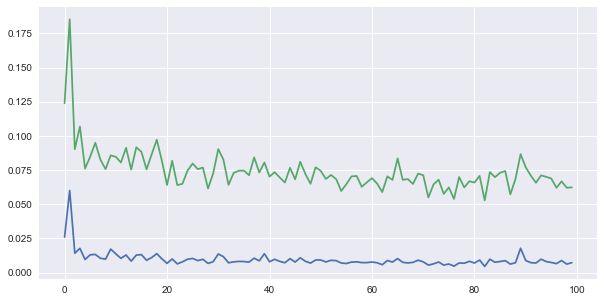

In [1441]:
plt.rcParams['figure.figsize'] = (10, 5)
loss = np.concatenate([h.history['loss'] for h in history])
mae = np.concatenate([h.history['mean_absolute_error'] for h in history])
#loss = history.history['loss']
#mae = history.history['mean_absolute_error']
plt.plot(loss)
plt.plot(mae)

0.2073123730514338

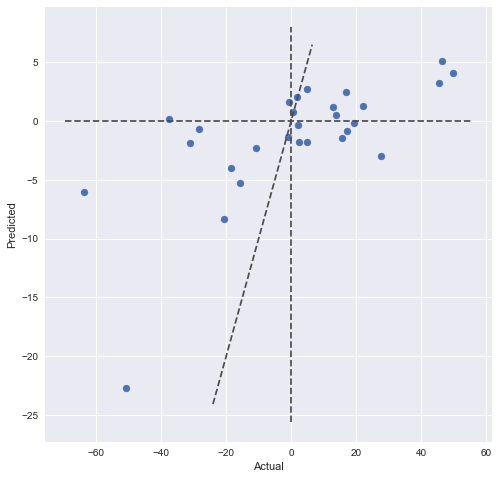

In [1442]:
model.reset_states()
y_pred = model.predict(xin, batch_size=X[0].shape[0])

y_pred = np.concatenate(y_pred)
y_pred = y_pred*ymax

plt.rcParams['figure.figsize'] = (8,8)
plt.scatter(Y[s], y_pred)
ax = plt.gca()
diag = max(ax.get_xlim(), ax.get_ylim())
ax.plot(diag, diag, ls="--", c=".3")
ax.plot([0,0], ax.get_ylim(), ls="--", c=".3")
ax.plot(ax.get_xlim(), [0,0], ls="--", c=".3")
plt.xlabel('Actual')
plt.ylabel('Predicted')

r2_score(Y[s], y_pred)

In [1448]:
pd.read_csv('test')

,OK,hours_solve_to_contest,hours_submit_to_contest,hours_submit_to_solve,oldrating,points,problem_rating,rank,smoothed_3months,java,lowlevel,python,otherlang,errors,wrong,practice
0,3.0,15220.209722,15220.330833,11329.624167,5000.0,3000.0,5000.0,4545.0,5000.0,1.0,2.0,1.0,1.0,7.0,27.0,2.0


In [1470]:
idx = [i for i in range(len(colnames)) if 'hours' in colnames[i]]
np.array(colnames)[idx]
maxtime = 24 * 30 * 6
maxtime = 10
print np.clip(X[0][4][1:10, idx], 0, maxtime)
print np.clip(X[0][4][1:10, idx], 0, maxtime)

[[ 10.          10.          10.        ]
 [ 10.          10.           0.01194444]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  0.          10.           0.        ]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  1.75972222   1.75972222   0.        ]
 [  0.           0.71138889   0.        ]]
[[ 10.          10.          10.        ]
 [ 10.          10.           0.01194444]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  0.          10.           0.        ]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  1.75972222   1.75972222   0.        ]
 [  0.           0.71138889   0.        ]]


# Train RNN on all users in train set

In [4]:
from train_model import *
# ------------------------------------------
# parameters
# ------------------------------------------
month = 3 
tags = set(['implementation', 'two pointers', 'data structures', '*special', 'probabilities', 'divide and conquer', 'shortest paths', 'meet-in-the-middle', 'trees', 'matrices', 'graph matchings', 'expression parsing', 'graphs', 'ternary search', 'dfs and similar', 'combinatorics', 'string suffix structures', 'games', 'binary search', '2-sat', 'brute force', 'hashing', 'dsu', 'chinese remainder theorem', 'flows', 'sortings', 'number theory', 'fft', 'greedy', 'schedules', 'math', 'strings', 'bitmasks', 'geometry', 'dp', 'constructive algorithms'])
ymax = 500.0
maxrating = 5000.0
maxpoints = 3000.0
maxtimepts = 100
maxtime = 24 * 30 * month * 2 
path = 'rnn_train/' 

# ------------------------------------------                                                                                                             
# Get list of handles in train/ test/ val
# ------------------------------------------
with open('set_val.txt') as f: 
    val_handles = [h.strip() for h in f.readlines()]


# user columns can be out of order, use tourist's as correct order
with open(path + 'tourist.csv') as f:
    correct_cols = [t.strip() for t in f.readline().split(',')]
    correct_cols = [c for c in correct_cols if c not in tags]

# ------------------------------------------
# Scaling
# ------------------------------------------
xmax = np.array([
        maxtimepts,
        maxtime,
        maxtime,
        maxtime,
        maxrating,
        maxpoints,
        maxrating,
        maxrating,
        maxtimepts,
        maxtimepts,
        maxtimepts,
        maxtimepts,
        maxtimepts,
        maxtimepts,
        maxtimepts
        ])

print list(xmax)


[100.0, 4320.0, 4320.0, 4320.0, 5000.0, 3000.0, 5000.0, 5000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


In [17]:
reload(keras_functions)
X, Y, _, _, colnames = keras_functions.get_train_data(['markelost'], binvars, correct_cols, maxtimepts, path, maxtime)

batchsize = X[0].shape
model = make_model(batchsize)

model.load_weights('model_weights.h5')

y_pred = model.predict(X[0]/xmax, batch_size=X[0].shape[0])

rnn_train/markelost.csv


(0, 0.3)

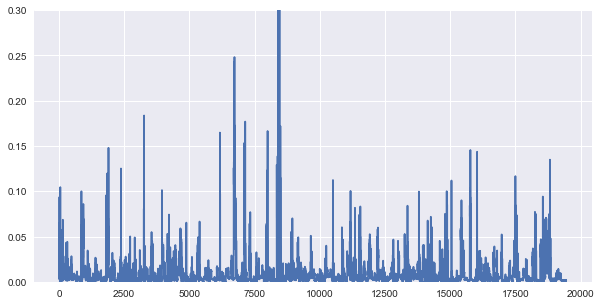

In [3]:
loss = pd.read_csv('training_loss.txt', header=None)
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(loss[0])
plt.ylim(0, .3)